***Prompt Labeling and Clustering Notebook***

In [248]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import umap
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import hdbscan
from matplotlib.colors import CSS4_COLORS, hex2color
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

sns.set_theme(style="whitegrid")

In [249]:
#Load data
# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "../data/training-set/chatbot-arena-prompts-embeddings.npy"
)

# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "../data/training-set/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

# objectives and topics csv import
objectives = pd.read_csv("../data/training-set/prompt_objectives.csv")
topics = pd.read_csv("../data/training-set/prompt_topics.csv")

In [250]:
#convert objectives and topics lists to dictionaries
# Function to convert comma-separated string to a list of keywords
def parse_keyword_string(value):
    if isinstance(value, str):
        # Split the string by ", " and strip any extra whitespace
        keywords = [keyword.strip() for keyword in value.split(",") if keyword.strip()]
        print(f"Parsed '{value}' to {keywords}")  # Debugging print
        return keywords
    return [] 

# Apply the parsing function to both DataFrames
objectives['prompt_objective_keywords'] = objectives['prompt_objective_keywords'].apply(parse_keyword_string)
topics['prompt_topic_keywords'] = topics['prompt_topic_keywords'].apply(parse_keyword_string)

# Verify the conversion worked
print(objectives.head())
print(topics.head())

#extract the dictionaries
objective_keywords = {
    row['prompt_objective']: row['prompt_objective_keywords']
    for _, row in objectives.iterrows()
    if pd.notna(row['prompt_objective']) and isinstance(row['prompt_objective_keywords'], list)
}

topic_keywords = {
    row['prompt_topic']: row['prompt_topic_keywords']
    for _, row in topics.iterrows()
    if pd.notna(row['prompt_topic']) and isinstance(row['prompt_topic_keywords'], list)
}

# Print the final dictionaries
print("\nObjective Keywords Dictionary:", objective_keywords)
print("Topic Keywords Dictionary:", topic_keywords)


Parsed 'comparison, compare, comparative, prefer, differen, relation, analogy' to ['comparison', 'compare', 'comparative', 'prefer', 'differen', 'relation', 'analogy']
Parsed 'reasoning, opinion, strategy, judgement, advice, critical thinking, decide, decision, logic, problem solving, inference, riddle, puzzle, recommendation, speculat' to ['reasoning', 'opinion', 'strategy', 'judgement', 'advice', 'critical thinking', 'decide', 'decision', 'logic', 'problem solving', 'inference', 'riddle', 'puzzle', 'recommendation', 'speculat']
Parsed 'analysis, extract, retrieval, describe, description, align, comprehen, recognition' to ['analysis', 'extract', 'retrieval', 'describe', 'description', 'align', 'comprehen', 'recognition']
Parsed 'counting, convert, measure' to ['counting', 'convert', 'measure']
Parsed 'explanation, explain, understand, summarize, definition, define, instructions' to ['explanation', 'explain', 'understand', 'summarize', 'definition', 'define', 'instructions']
Parsed 'cr

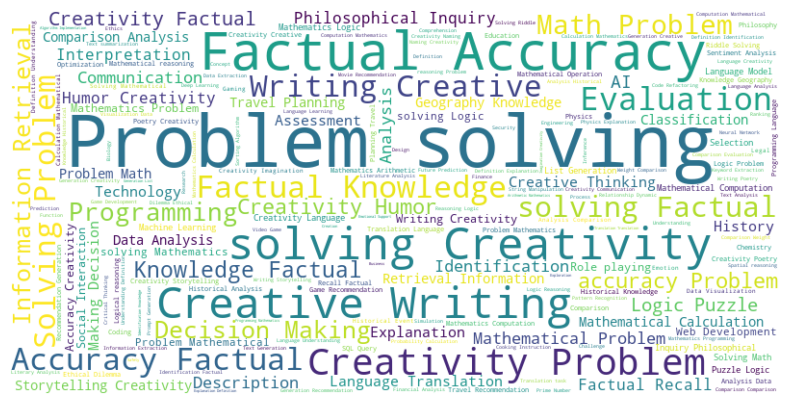

In [251]:
#generate wordcloud of topics
# Combine all topic columns into a single string
topics = (
    topic_and_hardness['topic_modeling_1'].astype(str) + ' ' +
    topic_and_hardness['topic_modeling_2'].astype(str) + ' ' +
    topic_and_hardness['topic_modeling_3'].astype(str)
).str.cat(sep=' ')

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topics)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.show()


In [252]:
#convert all topic_modeling columns to lowercase
topic_and_hardness["topic_modeling_1"] = topic_and_hardness["topic_modeling_1"].str.lower()
topic_and_hardness["topic_modeling_2"] = topic_and_hardness["topic_modeling_2"].str.lower()
topic_and_hardness["topic_modeling_3"] = topic_and_hardness["topic_modeling_3"].str.lower()
topic_and_hardness.head(1)

,question_id,prompt,openai_scores_raw_choices_nested,topic_modeling_1,score_reason_1,score_value_1,topic_modeling_2,score_reason_2,score_value_2,topic_modeling_3,score_reason_3,score_value_3
0,58210e39b3fd4441a2bd4a518bb44c2d,What is the difference between OpenCL and CUDA?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",technical comparison,This prompt requires the AI to accurately comp...,9,software comparison,This prompt assesses the AI's factual accuracy...,8,"comparison, technology",This prompt requires the AI to demonstrate kno...,9


In [253]:
topic_and_hardness = topic_and_hardness

In [254]:
# Function to find the closest matching objective or topic using regex
def find_match_regex(keywords_dict, text_columns):
    for key, keywords in keywords_dict.items():
        if not isinstance(keywords, list):
            continue
        for keyword in keywords:
            # Prepare a regex pattern to match the keyword exactly or partially (case-insensitive)
            pattern = rf"\b{re.escape(keyword.strip().lower())}\w*\b"
            
            for text in text_columns:
                if isinstance(text, str):
                    # Search for the pattern in the text
                    match = re.search(pattern, text.lower())
                    if match:
                        return key, keyword  # Return the first valid match
    return np.nan, np.nan  # Return True NaN if no match is found

# Safely collect text from topic_modeling columns
def safe_collect_text(row, columns):
    texts = []
    for col in columns:
        value = row.get(col)
        if pd.notna(value):  # Check if value is not NaN
            if isinstance(value, list):  # If it's a list, convert to string
                value = ' '.join(map(str, value))
            texts.append(str(value))  # Ensure it's treated as a string
    return texts

# Iterate through topic_and_hardness to generate the new columns
new_data = []
for index, row in topic_and_hardness.iterrows():
    # Collect all text from topic_modeling columns
    texts = safe_collect_text(row, ['topic_modeling_1', 'topic_modeling_2', 'topic_modeling_3'])

    # Find objective and topic matches using regex matching
    objective, objective_term = find_match_regex(objective_keywords, texts)
    topic, topic_term = find_match_regex(topic_keywords, texts)

    # Add new columns to the DataFrame with true NaN for non-matches
    new_data.append({
        **row,  # Keep the original row data
        'prompt_objective': objective if pd.notna(objective) else np.nan,
        'objective_term': objective_term if pd.notna(objective_term) else np.nan,
        'prompt_topic': topic if pd.notna(topic) else np.nan,
        'topic_term': topic_term if pd.notna(topic_term) else np.nan
    })

# Convert the new data to a DataFrame
topic_and_hardness_prompt_labels = pd.DataFrame(new_data)


In [255]:
print(topic_and_hardness_prompt_labels.shape)
topic_and_hardness_prompt_labels.head(5)

(25282, 16)


,question_id,prompt,openai_scores_raw_choices_nested,topic_modeling_1,score_reason_1,score_value_1,topic_modeling_2,score_reason_2,score_value_2,topic_modeling_3,score_reason_3,score_value_3,prompt_objective,objective_term,prompt_topic,topic_term
0,58210e39b3fd4441a2bd4a518bb44c2d,What is the difference between OpenCL and CUDA?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",technical comparison,This prompt requires the AI to accurately comp...,9,software comparison,This prompt assesses the AI's factual accuracy...,8,"comparison, technology",This prompt requires the AI to demonstrate kno...,9,comparing,comparison,programming,software
1,2564acd09e3942fd97657d05282d4389,Why did my parent not invite me to their wedding?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...","reasoning, emotion",This prompt requires the AI to understand huma...,9,"emotions, relationships",This prompt involves understanding complex hum...,8,"reasoning, emotional",This prompt challenges the AI to infer motives...,8,comparing,relation,Social,emotion
2,90bfd142157948aba01931726c888e7f,"Fuji vs. Nikon, which is better?","[{'finish_reason': 'stop', 'index': 0, 'logpro...",camera comparison,This prompt does not require problem-solving s...,2,comparative analysis,This prompt assesses the AI's ability to analy...,6,photography comparison,This prompt is subjective and does not provide...,2,comparing,comparison,technology,photography
3,a7c5accc53e649a3bc6b2e41d962ebc4,How to build an arena for chatbots?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",chatbot arena,This prompt requires problem-solving skills an...,8,chatbot arena,This prompt requires the AI to engage in probl...,8,chatbot arena,This prompt requires problem-solving skills an...,8,NaN,NaN,AI,chatbot
4,adf27e819a3c494cb6e993f0c660e097,When is it today?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",time query,This prompt is very straightforward and does n...,2,date inquiry,This prompt is very straightforward and does n...,2,time-based inquiry,This prompt is too straightforward and simply ...,2,NaN,NaN,NaN,NaN


In [256]:
#print number of missing values per new column
print (enhanced_df["prompt_objective"].isnull().sum())
print (enhanced_df["objective_term"].isnull().sum())
print (enhanced_df["prompt_topic"].isnull().sum())
print (enhanced_df["topic_term"].isnull().sum())

9346
9346
13090
13090


c:\Users\natha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


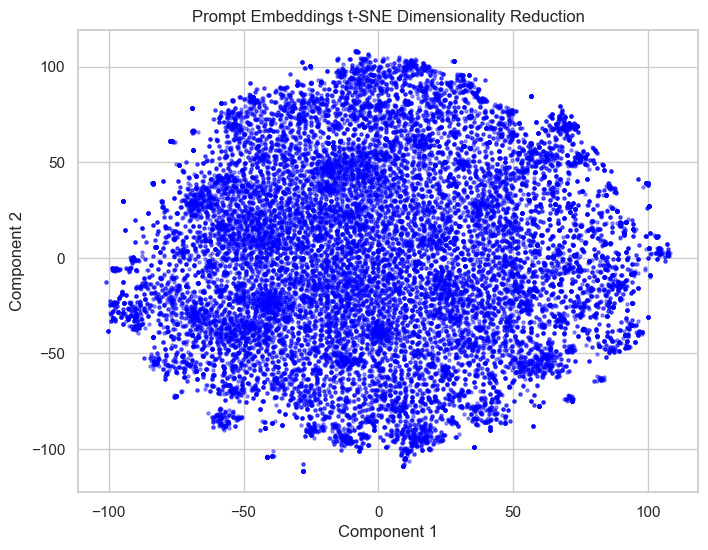

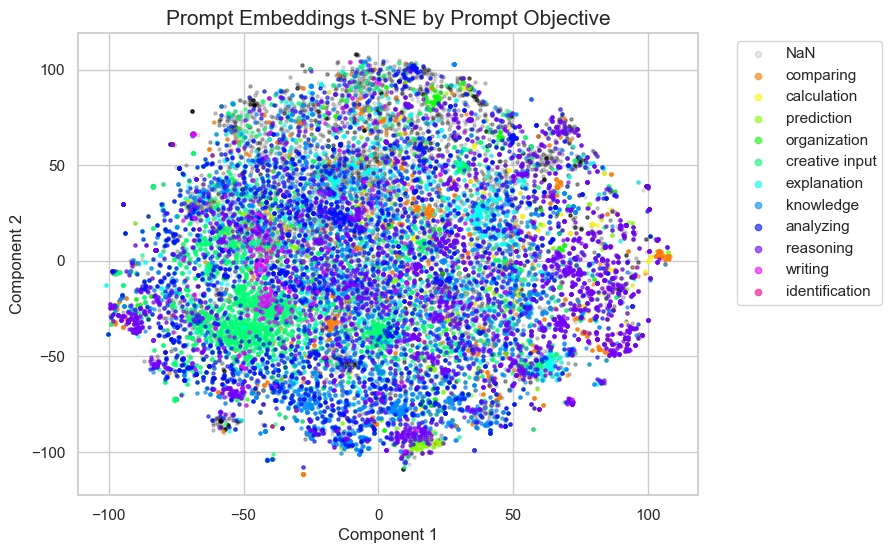

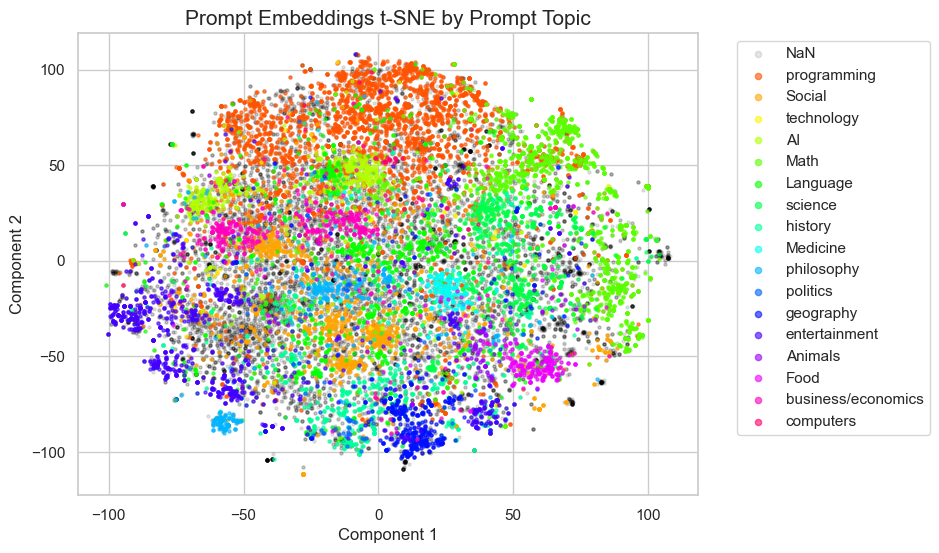

In [257]:
# Reduce dimensions to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(prompt_embeddings)

# 1. Non-colored t-SNE plot (all points in blue)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=5, alpha=0.4, color='blue')
plt.title('Prompt Embeddings t-SNE Dimensionality Reduction')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

# Helper function to create scatter plot with coloring
def plot_tsne_colored_by_category(tsne_results, category_labels, title):
    plt.figure(figsize=(8, 6))
    unique_labels = category_labels.dropna().unique()  # Exclude NaNs from unique labels
    palette = sns.color_palette("hsv", len(unique_labels))  # Create a color palette

    # Plot NaN points in black with low alpha (0.1)
    nan_indices = category_labels.isna()
    plt.scatter(
        tsne_results[nan_indices, 0], tsne_results[nan_indices, 1],
        label='NaN', s=5, alpha=0.1, color='black'
    )

    # Plot other categories with unique colors
    for label, color in zip(unique_labels, palette):
        indices = category_labels == label
        plt.scatter(
            tsne_results[indices, 0], tsne_results[indices, 1],
            label=label, s=5, alpha=0.6, color=color
        )

    plt.title(title, fontsize = 15)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# 2. t-SNE plot colored by 'prompt_objective'
plot_tsne_colored_by_category(
    tsne_results, enhanced_df['prompt_objective'], 
    'Prompt Embeddings t-SNE by Prompt Objective'
)

# 3. t-SNE plot colored by 'prompt_topic'
plot_tsne_colored_by_category(
    tsne_results, enhanced_df['prompt_topic'], 
    'Prompt Embeddings t-SNE by Prompt Topic'
) 

c:\Users\natha\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


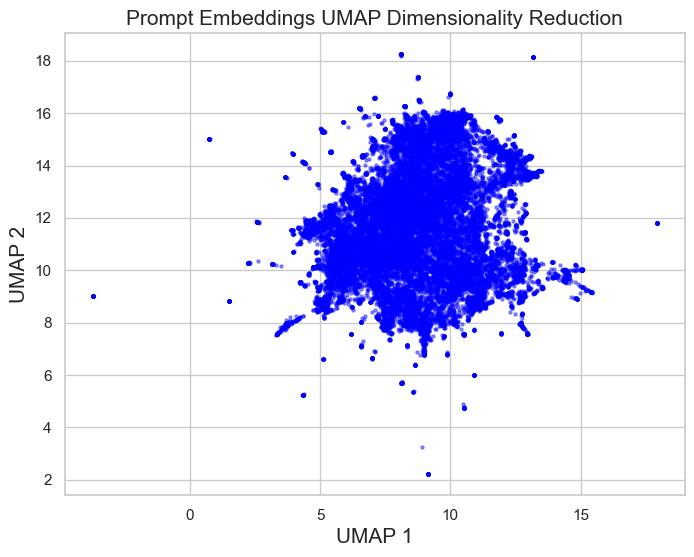

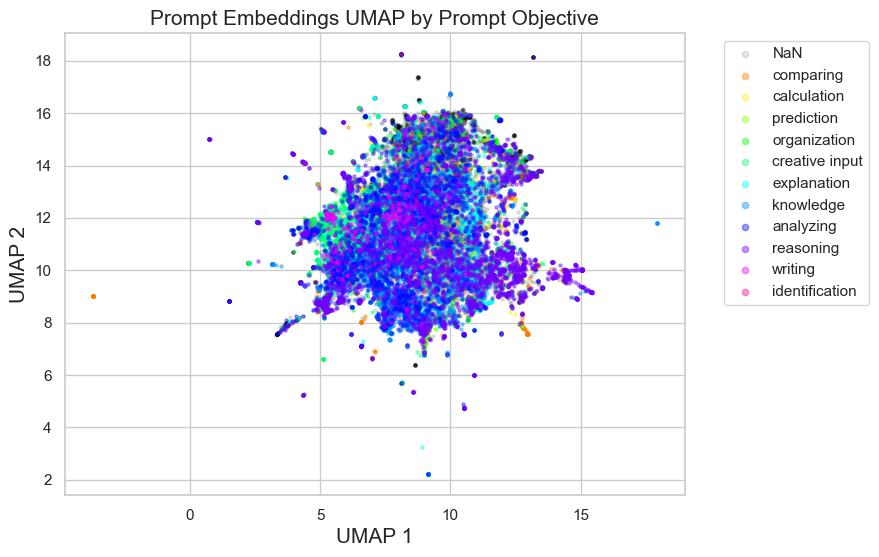

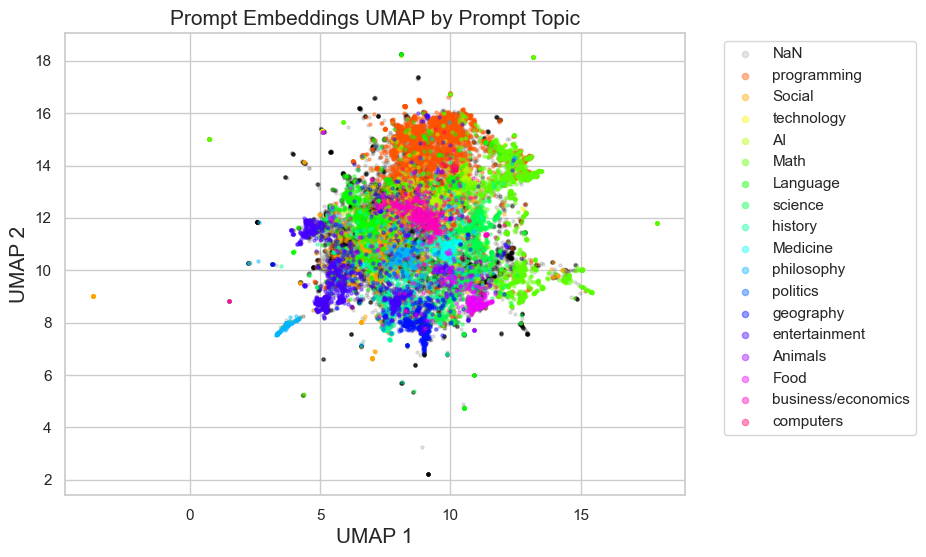

In [258]:
#Reduce dimensions to 2D using UMAP
umap_reducer = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.1, random_state=42)
umap_results = umap_reducer.fit_transform(prompt_embeddings)

#Non-colored UMAP plot (all points in blue)
plt.figure(figsize=(8, 6))
plt.scatter(umap_results[:, 0], umap_results[:, 1], s=5, alpha=0.4, color='blue')
plt.title('Prompt Embeddings UMAP Dimensionality Reduction', fontsize = 15)
plt.xlabel('UMAP 1', fontsize = 15)
plt.ylabel('UMAP 2', fontsize = 15)
plt.show()

#create scatter plot with coloring
def plot_umap_colored_by_category(umap_results, category_labels, title):
    plt.figure(figsize=(8, 6))
    unique_labels = category_labels.dropna().unique()  # Exclude NaNs from unique labels
    palette = sns.color_palette("hsv", len(unique_labels)) 

    #Plot NaN points in black with low alpha (0.1)
    nan_indices = category_labels.isna()
    plt.scatter(
        umap_results[nan_indices, 0], umap_results[nan_indices, 1],
        label='NaN', s=5, alpha=0.1, color='black'
    )

    #Plot other categories with unique colors
    for label, color in zip(unique_labels, palette):
        indices = category_labels == label
        plt.scatter(
            umap_results[indices, 0], umap_results[indices, 1],
            label=label, s=5, alpha=0.4, color=color
        )

    plt.title(title, fontsize = 15)
    plt.xlabel('UMAP 1', fontsize = 15)
    plt.ylabel('UMAP 2', fontsize = 15)
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

#UMAP plot colored by 'prompt_objective'
plot_umap_colored_by_category(
    umap_results, enhanced_df['prompt_objective'], 
    'Prompt Embeddings UMAP by Prompt Objective'
)

#UMAP plot colored by 'prompt_topic'
plot_umap_colored_by_category(
    umap_results, enhanced_df['prompt_topic'], 
    'Prompt Embeddings UMAP by Prompt Topic'
)


c:\Users\natha\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


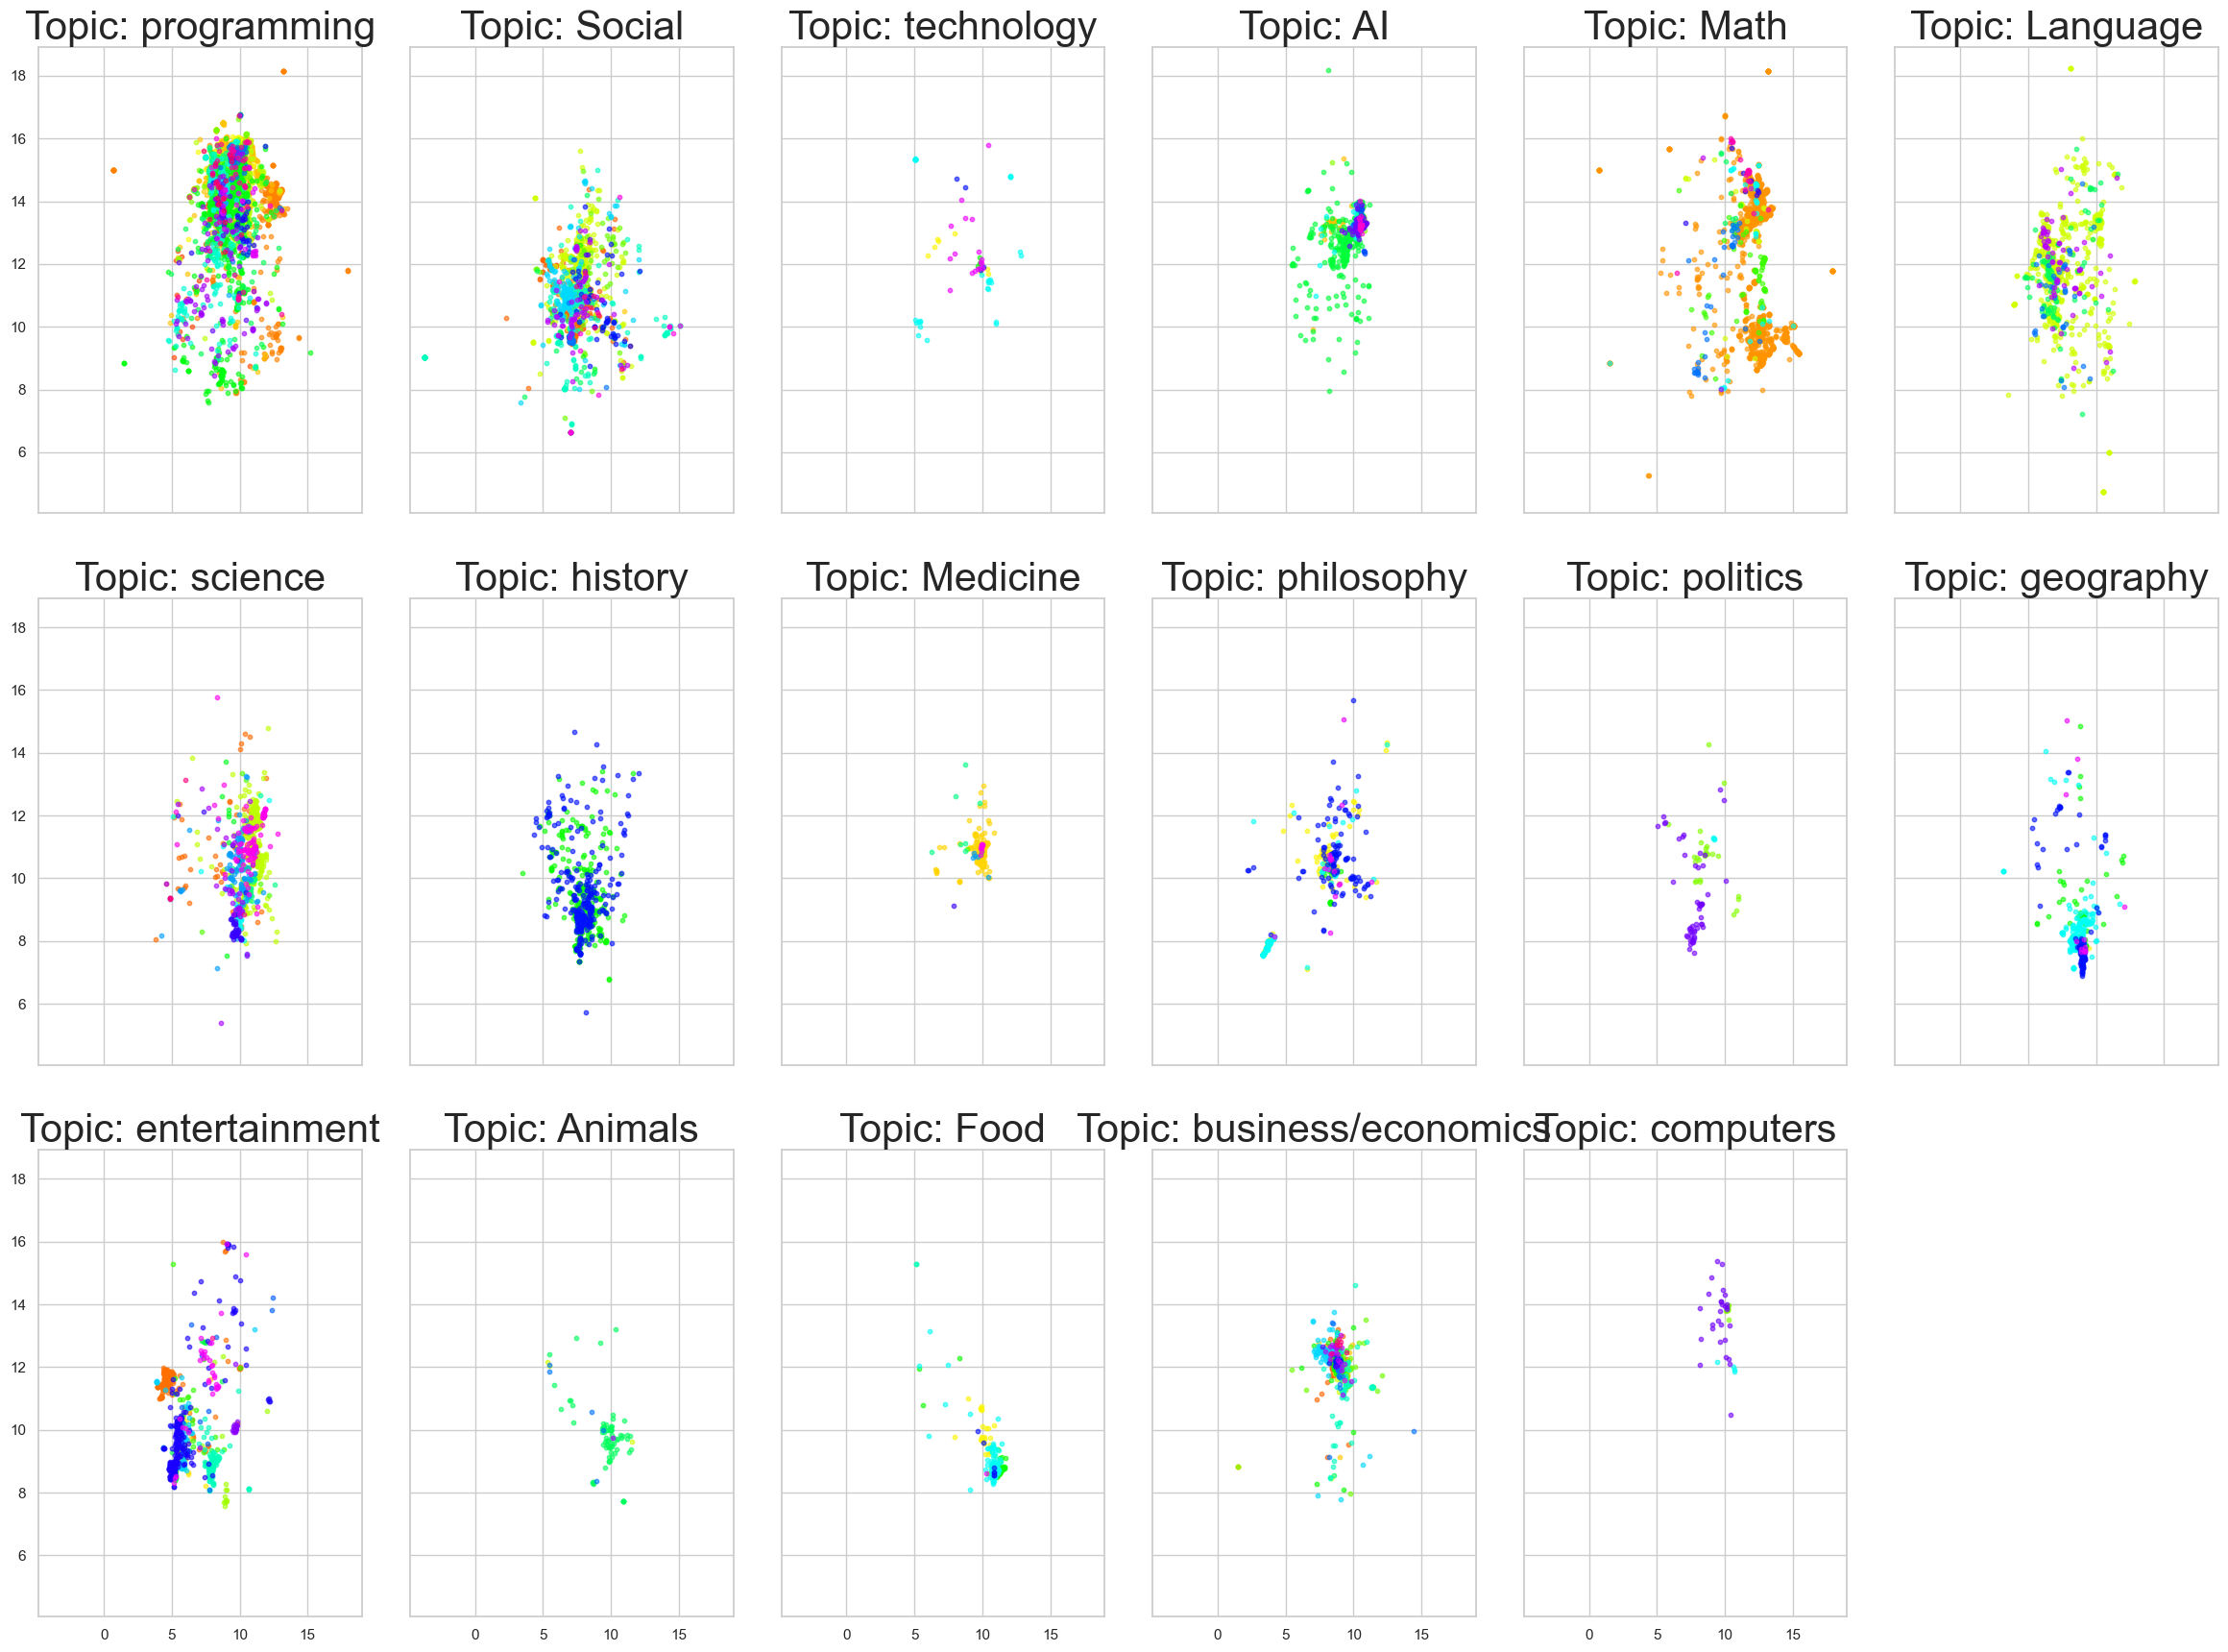



--- Legends with Named Colors ---
programming(software (orangered), computation (darkorange), programming (gold), string manipulation (yellow), algorithm (greenyellow), code (lawngreen), fine-tuning (lime), data (lime), app (springgreen), web development (mediumspringgreen), development (cyan), installation (cyan), operating systems (deepskyblue), python (dodgerblue), diffusion (blue), NLP (blue), cybersecurity (blueviolet), simulation (darkviolet), computing (magenta), debugging (magenta), coding (deeppink), API (crimson))
Social(emotion (orangered), politeness (gold), communication (yellow), education (lawngreen), child (lime), culture (springgreen), relationship (mediumspringgreen), humor (deepskyblue), greet (dodgerblue), behavior (blue), coach (blueviolet), personal (darkviolet), family (magenta), parenting (deeppink))
technology(photography (yellow), bitcoin (lime), mechanic (cyan), camera (blue), cryptocurrency (magenta))
AI(chatbot (orange), neural network (chartreuse), AI (l

In [271]:
def closest_color(rgb_color):
    min_colors = {}
    for name, hex_code in CSS4_COLORS.items():
        r_c, g_c, b_c = hex2color(hex_code)  # Convert hex to RGB
        r_c, g_c, b_c = [int(255 * c) for c in (r_c, g_c, b_c)]  
        distance = (r_c - rgb_color[0]) ** 2 + (g_c - rgb_color[1]) ** 2 + (b_c - rgb_color[2]) ** 2
        min_colors[distance] = name
    return min_colors[min(min_colors.keys())]

umap_reducer = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.1, random_state=42)
umap_results = umap_reducer.fit_transform(prompt_embeddings)

unique_topics = enhanced_df['prompt_topic'].dropna().unique()

# Create subplots
fig, axes = plt.subplots(3, 6, figsize=(24, 18), sharex=True, sharey=True)
axes = axes.flatten()
legends = []

# Helper function to plot each topic
for i, topic in enumerate(unique_topics):
    ax = axes[i]

    # Filter points by the current topic
    topic_indices = enhanced_df['prompt_topic'] == topic
    topic_umap = umap_results[topic_indices]
    topic_terms = enhanced_df.loc[topic_indices, 'topic_term']

    unique_terms = topic_terms.dropna().unique()
    palette = sns.color_palette("hsv", len(unique_terms))

    # Store the legend text for this topic with color info
    legend_text = [f"{topic}("]

    for term, color in zip(unique_terms, palette):
        term_indices = topic_terms == term
        ax.scatter(
            topic_umap[term_indices, 0], topic_umap[term_indices, 1],
            label=term, s=10, alpha=0.6, color=color
        )

        # Convert the RGB color to the nearest named color
        named_color = closest_color(tuple(int(255 * c) for c in color))
        legend_text.append(f"{term} ({named_color}), ")

    nan_indices = topic_terms.isna()
    if nan_indices.any():
        ax.scatter(
            topic_umap[nan_indices, 0], topic_umap[nan_indices, 1],
            label='NaN', s=10, alpha=0.1, color='black'
        )
        legend_text.append("NaN (black), ")

    legend_text[-1] = legend_text[-1].rstrip(", ") + ")"  # Remove trailing comma and close parenthesis
    legends.append("".join(legend_text))

    ax.set_title(f'Topic: {topic}', fontsize=30)
    ax.label_outer()

# Hide unused subplots
for j in range(len(unique_topics), len(axes)):
    axes[j].set_visible(False)
plt.tight_layout(pad=3.0)
plt.show()

# Print the legends with color information
print("\n\n--- Legends with Named Colors ---")
for legend in legends:
    print(legend)


c:\Users\natha\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Noise Percentage: 27.93%


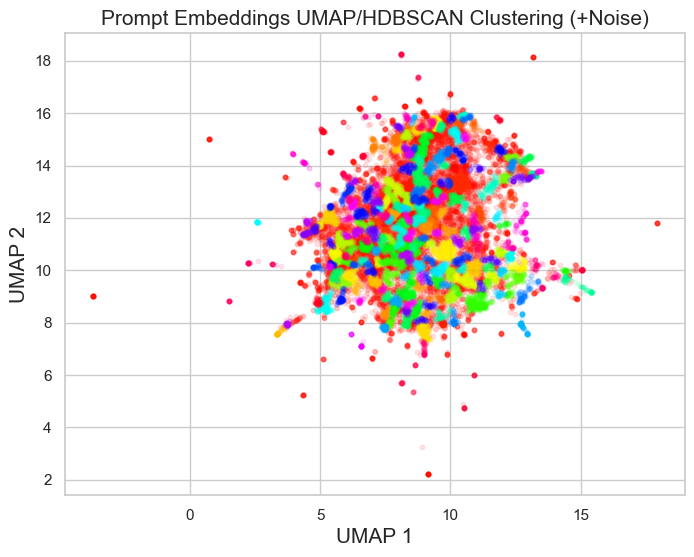

Number of clusters (excluding noise): 243


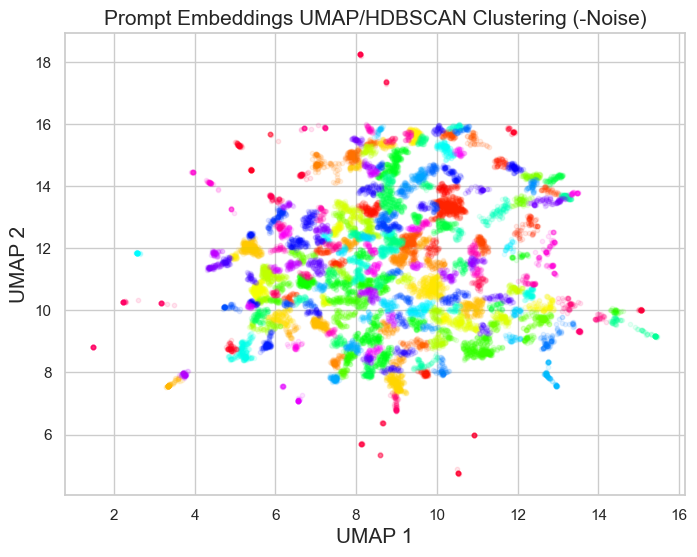

In [260]:
# UMAP + HDBSCAN and plotting function with noise and non-noise plots
def umap_hdbscan_clustering(prompt_embeddings, n_neighbors=50, min_cluster_size=10, min_samples=2):
    #UMAP dimensionality reduction
    umap_results = umap.UMAP(
        n_components=2, n_neighbors=n_neighbors, min_dist=0.1, random_state=42
    ).fit_transform(prompt_embeddings)

    #HDBSCAN clustering
    cluster_labels = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size, min_samples=min_samples, gen_min_span_tree=True
    ).fit_predict(umap_results)

    #Calculate and print noise percentage
    noise_pct = (sum(cluster_labels == -1) / len(cluster_labels)) * 100
    print(f"Noise Percentage: {noise_pct:.2f}%")

    #Prepare DataFrame with UMAP results and cluster labels
    umap_df = pd.DataFrame(umap_results, columns=['UMAP_1', 'UMAP_2'])
    umap_df['cluster'] = cluster_labels

    #Plot with noise included
    plt.figure(figsize=(8, 6))
    palette = sns.color_palette("hsv", len(umap_df['cluster'].unique()))

    for cluster, color in zip(umap_df['cluster'].unique(), palette):
        cluster_points = umap_df[umap_df['cluster'] == cluster]
        plt.scatter(cluster_points['UMAP_1'], cluster_points['UMAP_2'], s=10, alpha=0.1, color=color)

    plt.title(f'Prompt Embeddings UMAP/HDBSCAN Clustering (+Noise)', fontsize = 15)
    plt.xlabel('UMAP 1', fontsize = 15)
    plt.ylabel('UMAP 2', fontsize = 15)
    plt.show()

    #Plot without noise (filter out cluster -1)
    clustered_data = umap_df[umap_df['cluster'] != -1]
    num_clusters = len(clustered_data['cluster'].unique())
    print(f"Number of clusters (excluding noise): {num_clusters}")

    plt.figure(figsize=(8, 6))
    palette = sns.color_palette("hsv", num_clusters)

    for cluster, color in zip(clustered_data['cluster'].unique(), palette):
        cluster_points = clustered_data[clustered_data['cluster'] == cluster]
        plt.scatter(cluster_points['UMAP_1'], cluster_points['UMAP_2'], s=10, alpha=0.1, color=color)

    plt.title(f'Prompt Embeddings UMAP/HDBSCAN Clustering (-Noise)', fontsize = 15)
    plt.xlabel('UMAP 1', fontsize = 15)
    plt.ylabel('UMAP 2', fontsize = 15)
    plt.show()

umap_hdbscan_clustering(prompt_embeddings, n_neighbors=50, min_cluster_size=30, min_samples=1)


In [261]:
#hdbscan_cluster_series with all cluster labels, including noise (-1)
hdbscan_cluster_series = pd.Series(umap_df['cluster'], name='HDBSCAN_Cluster')
print(hdbscan_cluster_series.head())
num_clusters_including_noise = len(hdbscan_cluster_series.unique())
print(f"Total number of unique clusters (including noise): {num_clusters_including_noise}")


0    169
1     -1
2    131
3    190
4     69
Name: HDBSCAN_Cluster, dtype: int64
Total number of unique clusters (including noise): 244


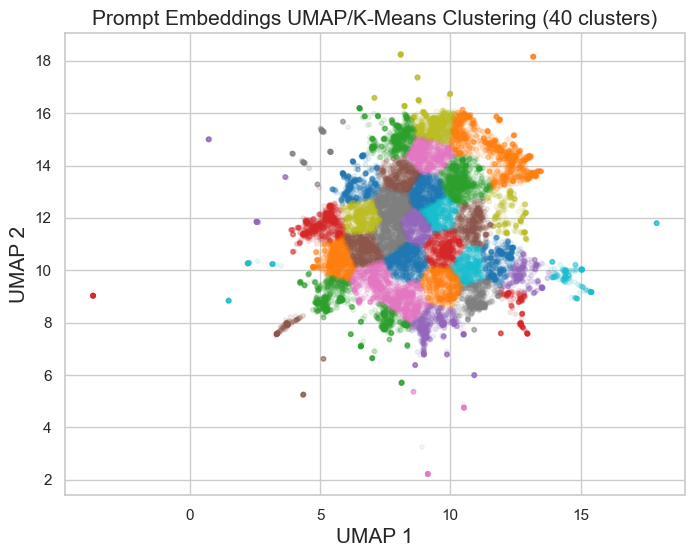

In [262]:
#Kmeans clustering
kmeans = KMeans(n_clusters=40, random_state=42)  # Adjust the number of clusters
kmeans_labels = kmeans.fit_predict(umap_results)

plt.figure(figsize=(8, 6))
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=kmeans_labels, cmap='tab10', s=10, alpha=0.1)
plt.title('Prompt Embeddings UMAP/K-Means Clustering (40 clusters)', fontsize = 15)
plt.xlabel('UMAP 1', fontsize = 15)
plt.ylabel('UMAP 2', fontsize = 15)
plt.show()


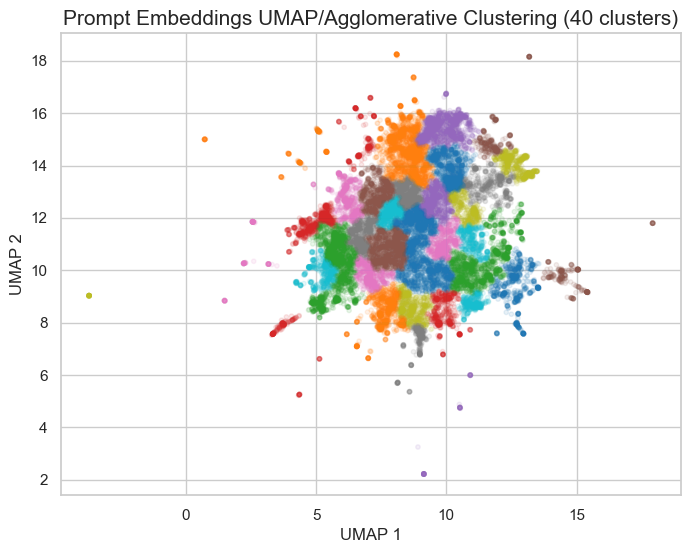

In [263]:
#Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=40)  # Adjust the number of clusters
agglo_labels = agglo.fit_predict(umap_results)

plt.figure(figsize=(8, 6))
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=agglo_labels, cmap='tab10', s=10, alpha=0.1)
plt.title('Prompt Embeddings UMAP/Agglomerative Clustering (40 clusters)', fontsize = 15)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()


In [264]:
# Generate and output the cluster series for Agglomerative Clustering
agglo_cluster_series = pd.Series(agglo_labels, name='Cluster', index=range(len(agglo_labels)))

# Print the structure and value counts to confirm the results
print(f"Total embeddings: {len(agglo_cluster_series)}")

Total embeddings: 25282


In [265]:
#make dataframe of cluster labels
embedding_cluster_labels = pd.DataFrame({
    'Agglo_Cluster': agglo_cluster_series,
    'HDBSCAN_Cluster': hdbscan_cluster_series
})
embedding_cluster_labels.head()

,Agglo_Cluster,HDBSCAN_Cluster
0,1,169
1,6,-1
2,18,131
3,30,190
4,14,69


In [269]:

topic_and_hardness_prompt_labels = topic_and_hardness_prompt_labels.merge(embedding_cluster_labels, left_index=True, right_index=True)
topic_and_hardness_prompt_labels.head(5)

,question_id,prompt,openai_scores_raw_choices_nested,topic_modeling_1,score_reason_1,score_value_1,topic_modeling_2,score_reason_2,score_value_2,topic_modeling_3,score_reason_3,score_value_3,prompt_objective,objective_term,prompt_topic,topic_term,Agglo_Cluster,HDBSCAN_Cluster
0,58210e39b3fd4441a2bd4a518bb44c2d,What is the difference between OpenCL and CUDA?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",technical comparison,This prompt requires the AI to accurately comp...,9,software comparison,This prompt assesses the AI's factual accuracy...,8,"comparison, technology",This prompt requires the AI to demonstrate kno...,9,comparing,comparison,programming,software,1,169
1,2564acd09e3942fd97657d05282d4389,Why did my parent not invite me to their wedding?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...","reasoning, emotion",This prompt requires the AI to understand huma...,9,"emotions, relationships",This prompt involves understanding complex hum...,8,"reasoning, emotional",This prompt challenges the AI to infer motives...,8,comparing,relation,Social,emotion,6,-1
2,90bfd142157948aba01931726c888e7f,"Fuji vs. Nikon, which is better?","[{'finish_reason': 'stop', 'index': 0, 'logpro...",camera comparison,This prompt does not require problem-solving s...,2,comparative analysis,This prompt assesses the AI's ability to analy...,6,photography comparison,This prompt is subjective and does not provide...,2,comparing,comparison,technology,photography,18,131
3,a7c5accc53e649a3bc6b2e41d962ebc4,How to build an arena for chatbots?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",chatbot arena,This prompt requires problem-solving skills an...,8,chatbot arena,This prompt requires the AI to engage in probl...,8,chatbot arena,This prompt requires problem-solving skills an...,8,NaN,NaN,AI,chatbot,30,190
4,adf27e819a3c494cb6e993f0c660e097,When is it today?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",time query,This prompt is very straightforward and does n...,2,date inquiry,This prompt is very straightforward and does n...,2,time-based inquiry,This prompt is too straightforward and simply ...,2,NaN,NaN,NaN,NaN,14,69


In [270]:
#save dataframe as csv to work with labels elsewhere
topic_and_hardness_prompt_labels.to_csv('../data/training-set/topic_hardness_embedding_cluster_labels.csv', index=True, header=True)
